# Forest Land Area (percentage of total land area)
In this notebook we will predict forest land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing forest data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging the forest area percentage variable  

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Mixed effect linear regression base line models
    - Fitting baseline model (mean model)
    - Fitting simple mixed effects model (time, population)
    
- Mixed effect linear regression theory driven models (social)
    - Social theory driven model 
    - Full social model 

- Mixed effect linear regression theory driven models (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model

Model comparison: 
- Compare model predictions 


# Data cleaning

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [68]:
#Read file 
df = pd.read_csv('Data/forest_area_percent.csv', skiprows=4)

Removing: 
- columns with 0 counts (keeping from 1990-2021)
- non-iso countries

In [69]:
#Remove columns with 0 counts
summary = df.describe()

count_row = summary.loc['count']

columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

df_90 = df.drop(columns=columns_with_zero_count)

display(df_90)

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,Forest area (% of land area),AG.LND.FRST.ZS,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,...,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333
1,Africa Eastern and Southern,AFE,Forest area (% of land area),AG.LND.FRST.ZS,36.230006,36.078752,35.927499,35.776246,35.624993,35.473739,...,31.890654,31.680635,31.470634,31.260420,31.039682,30.824316,30.611512,30.391626,30.174253,29.955194
2,Afghanistan,AFG,Forest area (% of land area),AG.LND.FRST.ZS,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,...,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782
3,Africa Western and Central,AFW,Forest area (% of land area),AG.LND.FRST.ZS,22.776908,22.658746,22.540583,22.422421,22.304258,22.186096,...,20.498099,20.410143,20.322187,20.234231,20.152610,20.071327,19.986100,19.901215,19.816777,19.732037
4,Angola,AGO,Forest area (% of land area),AG.LND.FRST.ZS,63.578070,63.453407,63.328745,63.204082,63.079419,62.954757,...,56.988751,56.543526,56.098301,55.653076,55.207845,54.762629,54.317406,53.872175,53.426951,52.981722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Forest area (% of land area),AG.LND.FRST.ZS,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,...,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832
263,South Africa,ZAF,Forest area (% of land area),AG.LND.FRST.ZS,14.955271,14.925265,14.895259,14.865253,14.835247,14.805241,...,14.295139,14.265133,14.235127,14.205121,14.175115,14.145109,14.115103,14.085097,14.055091,14.025085
264,Zambia,ZMB,Forest area (% of land area),AG.LND.FRST.ZS,63.778098,63.729940,63.681782,63.633624,63.585467,63.537309,...,62.308667,62.055529,61.802392,61.549254,61.295955,61.042885,60.789707,60.536515,60.283337,60.030150


In [70]:
#Removing non countries 
ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

df_iso = df_90[df_90['Country Code'].isin(ISO_list)]

print(df_iso)

     Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  Forest area (% of land area)  AG.LND.FRST.ZS   
2     Afghanistan          AFG  Forest area (% of land area)  AG.LND.FRST.ZS   
4          Angola          AGO  Forest area (% of land area)  AG.LND.FRST.ZS   
5         Albania          ALB  Forest area (% of land area)  AG.LND.FRST.ZS   
6         Andorra          AND  Forest area (% of land area)  AG.LND.FRST.ZS   
..            ...          ...                           ...             ...   
260         Samoa          WSM  Forest area (% of land area)  AG.LND.FRST.ZS   
262   Yemen, Rep.          YEM  Forest area (% of land area)  AG.LND.FRST.ZS   
263  South Africa          ZAF  Forest area (% of land area)  AG.LND.FRST.ZS   
264        Zambia          ZMB  Forest area (% of land area)  AG.LND.FRST.ZS   
265      Zimbabwe          ZWE  Forest area (% of land area)  AG.LND.FRST.ZS   

          1990       1991       1992   

Make the wide df long instead.

In [71]:
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='forest_area')
melted_df['Year'] = melted_df['Year'].astype(float)
print(melted_df)

     Country Code  Country Name                Indicator Name  Indicator Code  \
0             ABW         Aruba  Forest area (% of land area)  AG.LND.FRST.ZS   
1             AFG   Afghanistan  Forest area (% of land area)  AG.LND.FRST.ZS   
2             AGO        Angola  Forest area (% of land area)  AG.LND.FRST.ZS   
3             ALB       Albania  Forest area (% of land area)  AG.LND.FRST.ZS   
4             AND       Andorra  Forest area (% of land area)  AG.LND.FRST.ZS   
...           ...           ...                           ...             ...   
6875          WSM         Samoa  Forest area (% of land area)  AG.LND.FRST.ZS   
6876          YEM   Yemen, Rep.  Forest area (% of land area)  AG.LND.FRST.ZS   
6877          ZAF  South Africa  Forest area (% of land area)  AG.LND.FRST.ZS   
6878          ZMB        Zambia  Forest area (% of land area)  AG.LND.FRST.ZS   
6879          ZWE      Zimbabwe  Forest area (% of land area)  AG.LND.FRST.ZS   

        Year  forest_area  

In [72]:
sns.histplot(data=melted_df, x='forest_area', binwidth=0.1)
plt.show()

KeyboardInterrupt: 

We can see that we have countries that have 0 percent, which probably just is an indicator of not being able to record forest areas. 

In [ ]:
#Making a list for all countries that have exactly 0.0 percent forest and removing those. 

zero_countries = melted_df.groupby('Country Code')['forest_area'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

forest = melted_df[~melted_df['Country Code'].isin(zero_countries)]

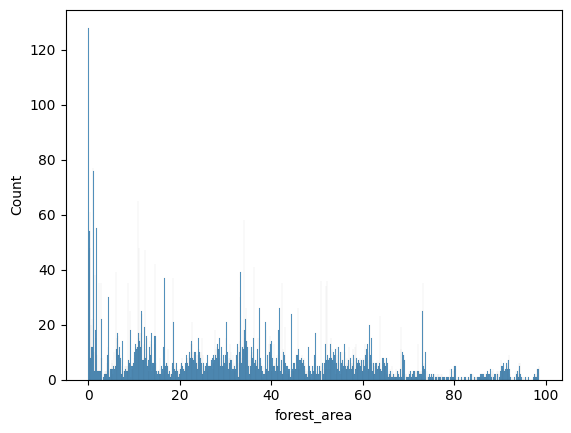

In [ ]:
sns.histplot(data=forest, x='forest_area', binwidth=0.1)
plt.show()

We still do have a lot around 0, but no values of 0.0 anymore. Which means that the rest must be correct numbers.

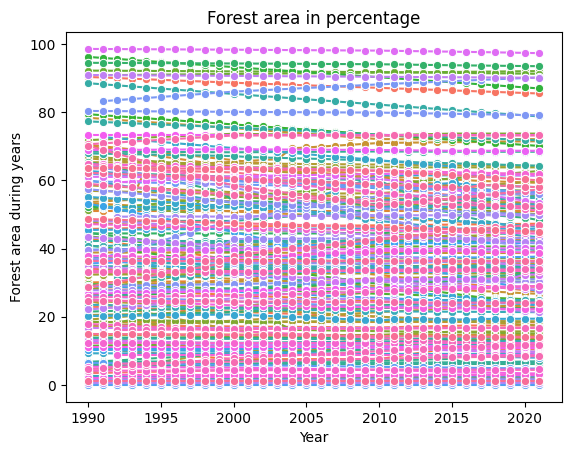

In [ ]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Code', marker='o', legend=False)

# Add title and labels
plt.title('Forest area in percentage')
plt.xlabel('Year')
plt.ylabel('Forest area during years')


# Show the plot
plt.show()

### Combine with predictor data 

In [ ]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                           Country Name Country Code  Year  Population, total  \
0                                 Aruba          ABW  1960            54608.0   
1           Africa Eastern and Southern          AFE  1960        130692579.0   
2                           Afghanistan          AFG  1960          8622466.0   
3            Africa Western and Central          AFW  1960         97256290.0   
4                                Angola          AGO  1960          5357195.0   
...                                 ...          ...   ...                ...   
17769                         Swaziland          SWZ  2021                NaN   
17770      Tanzania, United Republic of          TZA  2021                NaN   
17771                            Turkey          TUR  2021                NaN   
17772  Venezuela, Bolivarian Republic o          VEN  2021                NaN   
17773                             Yemen          YEM  2021                NaN   

       Land area (sq. km)  

In [ ]:
#Renaming so no double names
forest = forest.rename(columns={'Country Name':'Country'})

#combining forest and pred data
forest_full = pd.merge(forest, pred, on = ['Year', 'Country Code'], how = 'inner')

#removing excess country column
forest_full = forest_full.drop(columns=['Country'])


Removing countries with all NaN in one column or half of the variables in the columns is NaN.

In [ ]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
forest_full_filtered = forest_full[(forest_full['Year'] >= 1996) & (forest_full['Year'] <= 2020)]

#forest_full_filtered.info()

# Identify countries with NaN in forest_area (total of 8 countries)
countries_with_nan = forest_full_filtered[
    (forest_full_filtered['forest_area'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
forest_full_filtered = forest_full_filtered[~forest_full_filtered['Country Code'].isin(countries_with_nan)]

#Checkin how many countries were removed
#print(len(forest_full_filtered['Country Code'].unique()))
#print(len(forest_full['Country Code'].unique()))


In [ ]:
# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'forest_area', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = forest_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
forest_full_filtered = forest_full_filtered[forest_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

#Checking how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))

189
209


In [ ]:
# Remove rows with 'Country Code' equal to 'NIU'
#forest_full_filtered = forest_full_filtered[forest_full_filtered['Country Code'] != 'NIU']

# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = forest_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
forest_full_filtered = forest_full_filtered[~forest_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

#Checking how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))

Countries removed using country code: ['ASM', 'EGY', 'PRI', 'IRN', 'GMB', 'BOL', 'STP', 'GUM', 'TZA', 'MKD', 'LCA', 'CIV', 'LBY', 'BHS', 'MDA', 'KNA', 'GRL', 'VIR', 'SVK', 'COG', 'ABW', 'LAO', 'YEM', 'CPV', 'CZE', 'VEN', 'TUR', 'VNM', 'SWZ', 'KOR', 'KGZ', 'FSM', 'VCT', 'CYM', 'LIE', 'PRK', 'BMU']
152
209


In [ ]:
print(len(forest_full_filtered['Country Code'].unique()))
print(forest_full_filtered.isna().sum())

152
Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area              0
Country Name             0
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                  24
WGI GE                  56
WGI RQ                  56
WGI RL                   1
WGI CC                  46
Education             1168
Innovation            1491
Social Inequality     2064
ICT                    760
Health                   0
dtype: int64


We end up with 152 countries, and the relevant predictors mostly have fewer than 60 NaN. Then we impute the data for each of the countries where at least half of the observations are not NaN.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = forest_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'forest_area', 'Education', 'Innovation', 'Social Inequality'
]

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
forest_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(forest_full_imputed)

Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [ ]:
forest_full_imputed.isna().sum()

Country Code             0
Country Name             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area              0
Education             1168
Innovation            1491
Social Inequality     2064
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64

In [ ]:
forest_full_imputed = forest_full_imputed.drop(columns=['Indicator Name', 'Indicator Code', 'Education', 'Innovation', 'Social Inequality'])
forest_full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344 entries, 0 to 3343
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        3344 non-null   object 
 1   Country Name        3344 non-null   object 
 2   Year                3344 non-null   float64
 3   forest_area         3344 non-null   float64
 4   Population, total   3344 non-null   float64
 5   Land area (sq. km)  3344 non-null   float64
 6   WGI VA              3344 non-null   float64
 7   WGI PS              3344 non-null   float64
 8   WGI GE              3344 non-null   float64
 9   WGI RQ              3344 non-null   float64
 10  WGI RL              3344 non-null   float64
 11  WGI CC              3344 non-null   float64
 12  ICT                 3344 non-null   float64
 13  Health              3344 non-null   float64
dtypes: float64(12), object(2)
memory usage: 365.9+ KB


Delaying the forest area variable.

In [ ]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
forest_full_imputed['lagged_forest'] = pd.NA

#Iterating over each row
for i in range(len(forest_full_imputed)):
    country = forest_full_imputed.loc[i, 'Country Code']
    year = forest_full_imputed.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = forest_full_imputed[(forest_full_imputed['Country Code'] == country) & (forest_full_imputed['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        forest_full_imputed.loc[i, 'lagged_forest'] = lagged_row['forest_area'].values[0]

#Display the new dataframe 
display(forest_full_imputed)

,Country Code,Country Name,Year,forest_area,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,1.852782,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,1.852782
1,AFG,Afghanistan,1998.0,1.852782,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,1.852782
2,AFG,Afghanistan,2000.0,1.852782,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,1.852782
3,AFG,Afghanistan,2002.0,1.852782,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,1.852782
4,AFG,Afghanistan,2003.0,1.852782,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,1.852782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,45.570273,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,45.093912
3340,ZWE,Zimbabwe,2017.0,45.451183,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3341,ZWE,Zimbabwe,2018.0,45.332093,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3342,ZWE,Zimbabwe,2019.0,45.213002,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [ ]:
#Checking if the lagged is correct 
print(forest_full_imputed[(forest_full_imputed['Country Code'] == 'ZWE') & (forest_full_imputed['Year'] == 2000.0)]['forest_area'])

print(forest_full_imputed[(forest_full_imputed['Country Code'] == 'ZWE') & (forest_full_imputed['Year'] == 1996.0)]['lagged_forest'])

3324    47.475714
Name: forest_area, dtype: float64
3322    47.475714
Name: lagged_forest, dtype: object


In [ ]:
forest_full_imputed['lagged_forest'] = pd.to_numeric(forest_full_imputed['lagged_forest'])
forest_full_imputed = forest_full_imputed.rename(columns={'Land area (sq. km)':'land_area'})
forest_full_imputed = forest_full_imputed.rename(columns={'Population, total':'population'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI VA':'WGI_va'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI GE':'WGI_ge'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI RL':'WGI_rl'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI RQ':'WGI_rq'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI PS':'WGI_ps'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI CC':'WGI_cc'})
forest_full_imputed =forest_full_imputed.dropna()

display(forest_full_imputed)

,Country Code,Country Name,Year,forest_area,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,1.852782,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,1.852782
1,AFG,Afghanistan,1998.0,1.852782,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,1.852782
2,AFG,Afghanistan,2000.0,1.852782,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,1.852782
3,AFG,Afghanistan,2002.0,1.852782,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,1.852782
4,AFG,Afghanistan,2003.0,1.852782,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,1.852782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,46.046633,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,45.570273
3336,ZWE,Zimbabwe,2013.0,45.927543,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,45.451183
3337,ZWE,Zimbabwe,2014.0,45.808453,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,45.332093
3338,ZWE,Zimbabwe,2015.0,45.689363,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,45.213002


In [ ]:
print(forest_full_imputed.isna().sum())
print(len(forest_full_imputed['Country Code'].unique()))

Country Code     0
Country Name     0
Year             0
forest_area      0
population       0
land_area        0
WGI_va           0
WGI_ps           0
WGI_ge           0
WGI_rq           0
WGI_rl           0
WGI_cc           0
ICT              0
Health           0
lagged_forest    0
dtype: int64
152


### Save combined clean data 

In [ ]:
forest_full_imputed.to_csv('git_data/forest-modelling.csv', index=False)

# Data exploration

In [ ]:
#Load in cleaned data 
forest = pd.read_csv('git_data/forest-modelling.csv')

forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Code   2736 non-null   object 
 1   Country Name   2736 non-null   object 
 2   Year           2736 non-null   float64
 3   forest_area    2736 non-null   float64
 4   population     2736 non-null   float64
 5   land_area      2736 non-null   float64
 6   WGI_va         2736 non-null   float64
 7   WGI_ps         2736 non-null   float64
 8   WGI_ge         2736 non-null   float64
 9   WGI_rq         2736 non-null   float64
 10  WGI_rl         2736 non-null   float64
 11  WGI_cc         2736 non-null   float64
 12  ICT            2736 non-null   float64
 13  Health         2736 non-null   float64
 14  lagged_forest  2736 non-null   float64
dtypes: float64(13), object(2)
memory usage: 320.8+ KB


### Plotting and data exploration

Forest area per country over years.

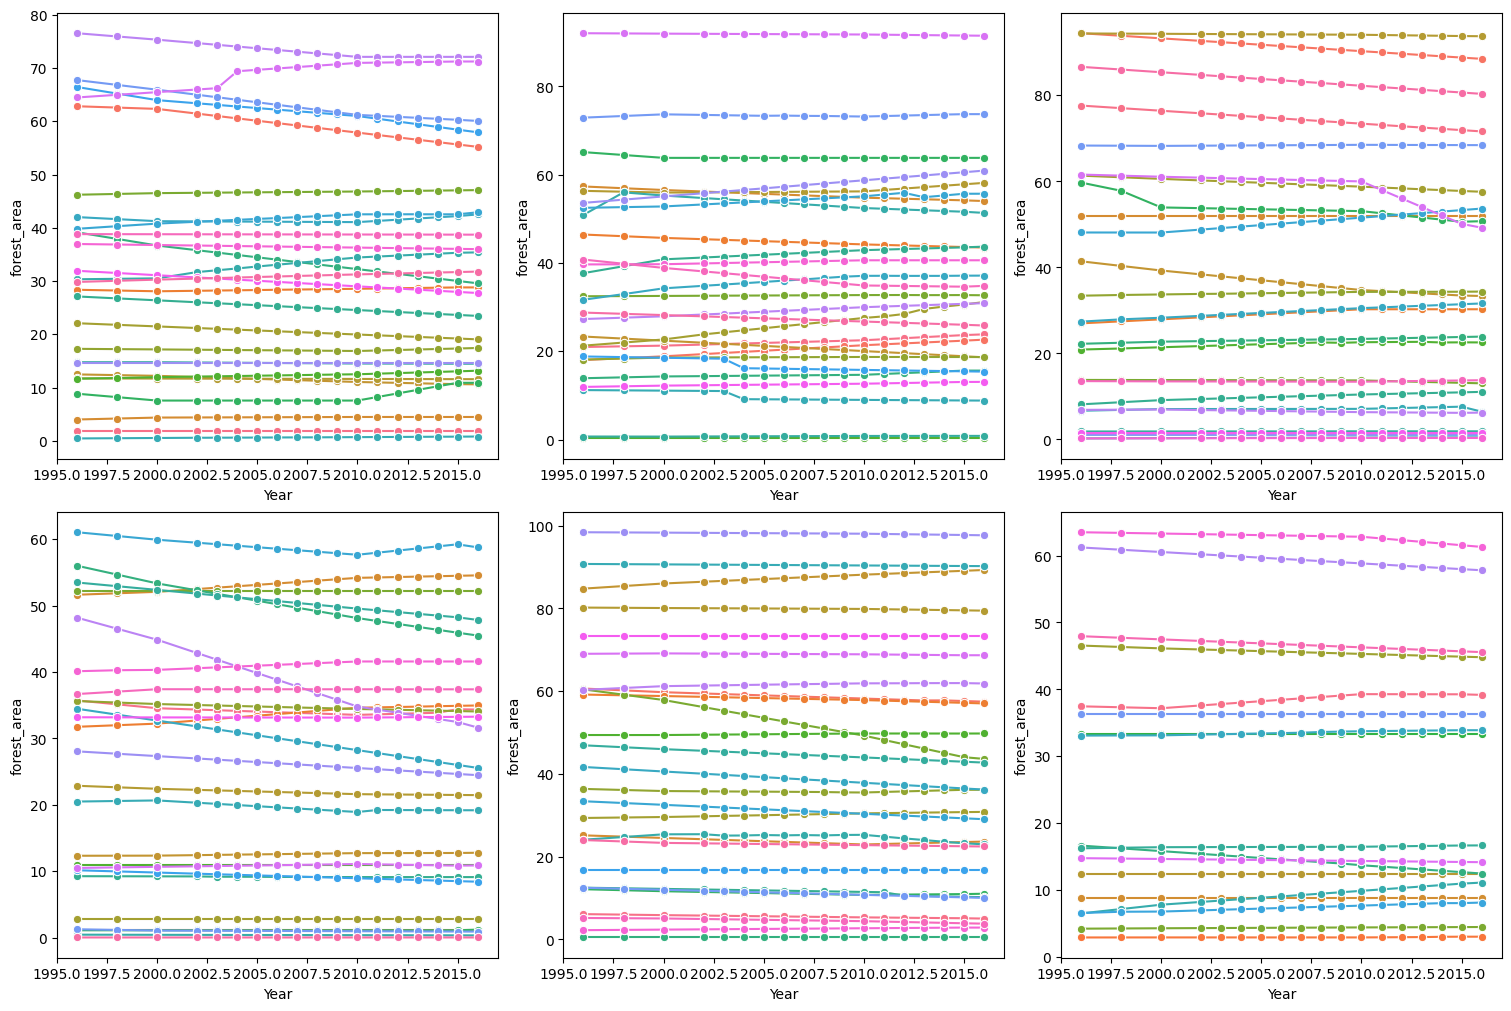

In [104]:
#Dividing by contries
countries = forest['Country Code'].unique()
countries_per_fig = 27
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = forest[forest['Country Code'].isin(group)]
    sns.lineplot(x='Year', y='forest_area', data= data, hue = 'Country Code', marker='o', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

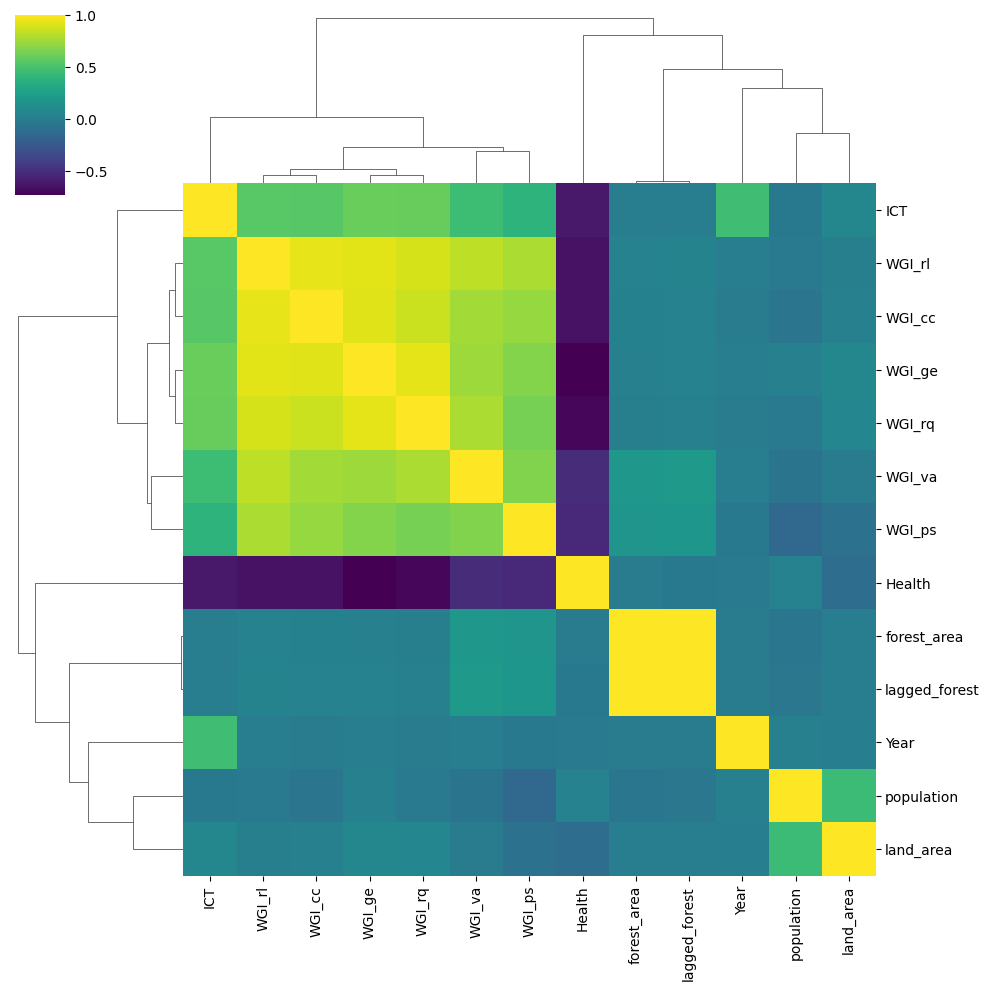

In [105]:
forest_num = forest[forest.select_dtypes(exclude=['object']).columns]

sns.clustermap(forest_num.corr(), cmap='viridis')
plt.show()

### Checking for outliers 

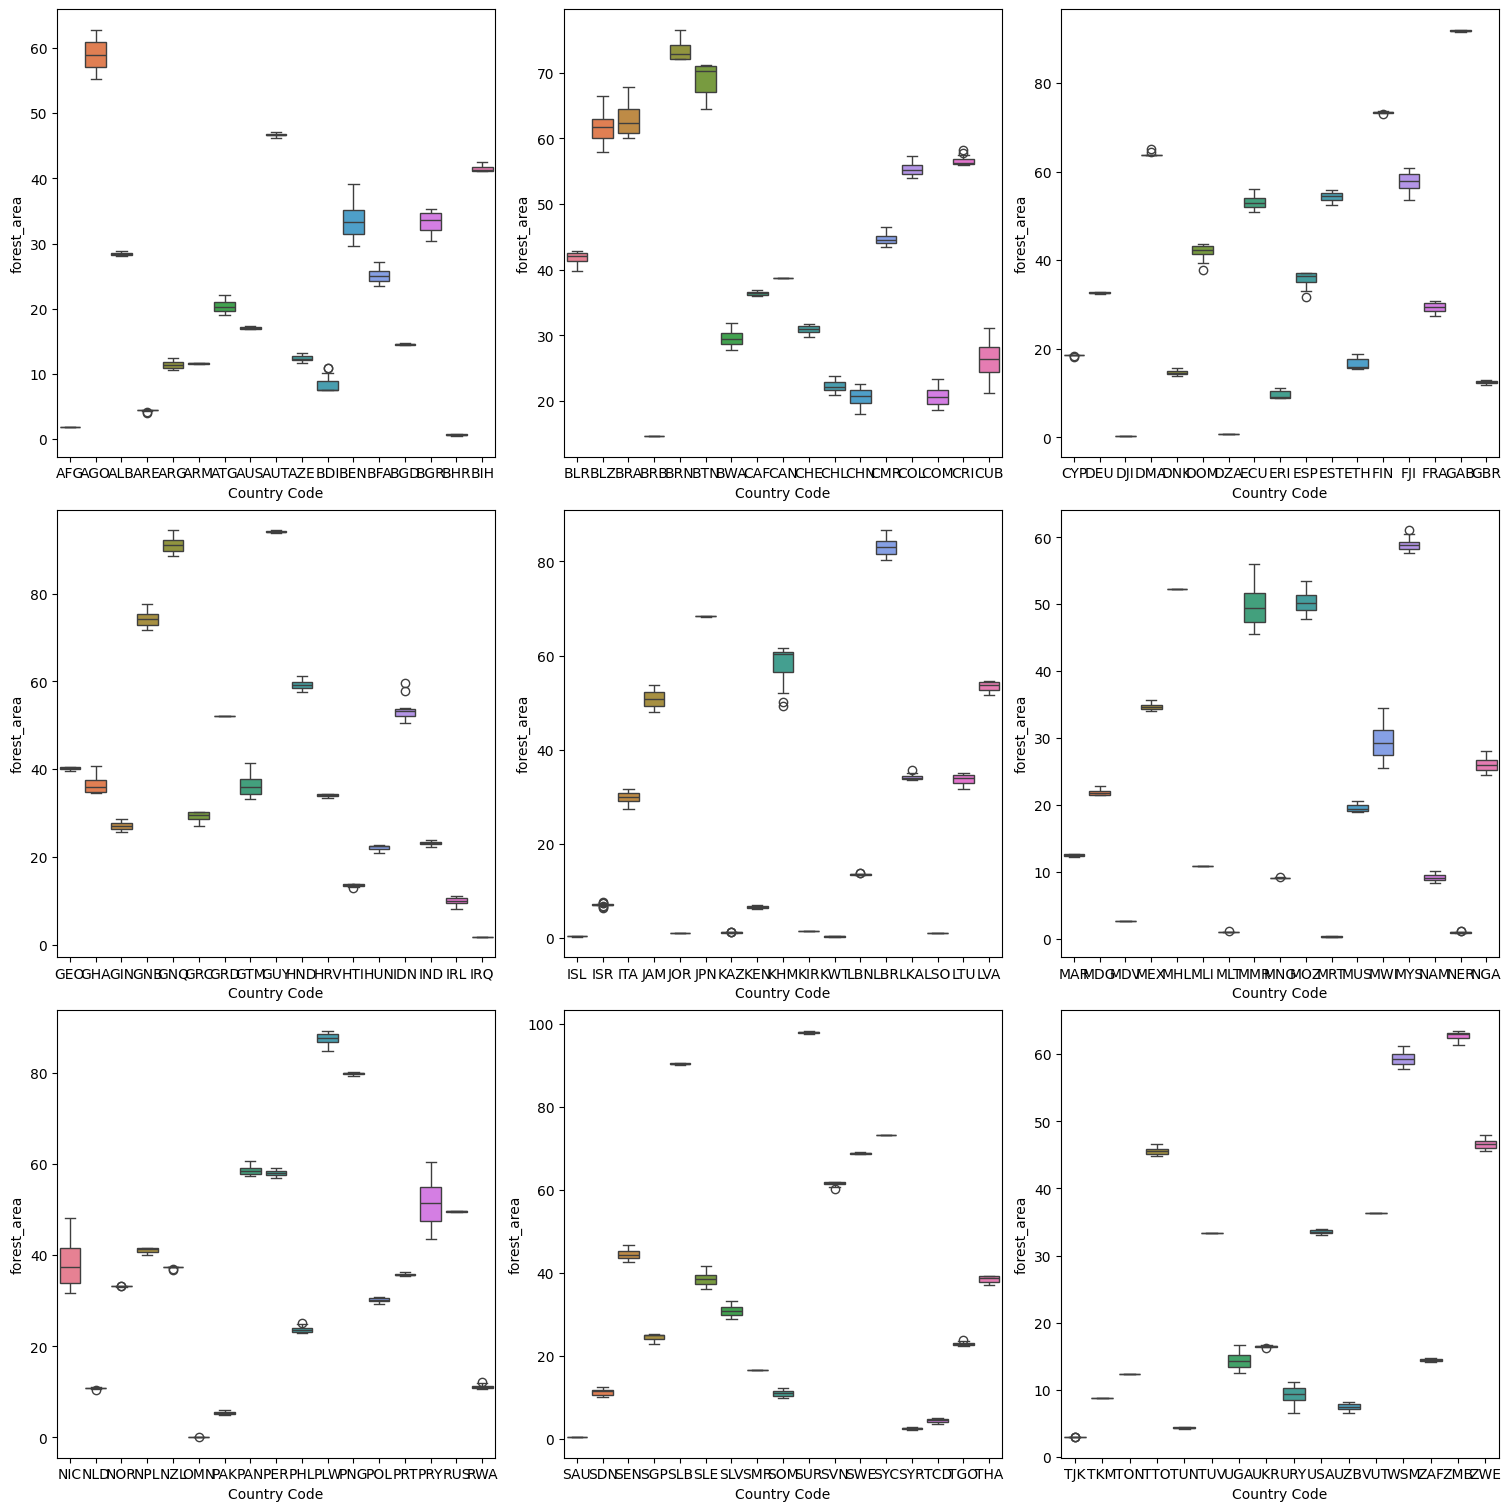

In [112]:
#Dividing by contries
countries = forest['Country Code'].unique()
countries_per_fig = 17
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = forest[forest['Country Code'].isin(group)]
    sns.boxplot(x='Country Code', y='forest_area', data= data, hue = 'Country Code', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [131]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_forest'].quantile(0.25)
    Q3 = group['lagged_forest'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_forest'] < lower_bound) | (group['lagged_forest'] > upper_bound)]

# Group by 'Country Code' and apply the outlier detection function
outliers = forest.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Total number of outliers
total_outliers = outliers.shape[0]
print("\nTotal number of outliers:", total_outliers)

# Number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()
print("\nNumber of outliers per 'Country Code':")
print(outliers_per_country)
print(f'Number of countries with outliers: {len(outliers_per_country)}')
print(f'Number of countries with 2 or more outliers: {(outliers_per_country > 2).sum()}')
print(f'Max number of outliers per country: {max(outliers_per_country)}')


Total number of outliers: 70

Number of outliers per 'Country Code':
Country Code
ARE    2
BGD    1
BGR    1
BLR    1
BRN    2
BTN    2
CYP    3
DEU    2
DJI    4
DZA    2
ERI    2
ESP    2
ETH    2
GEO    2
GHA    2
GRC    2
HRV    1
HUN    3
JPN    2
KEN    1
KWT    2
LTU    1
LVA    1
MAR    1
MDG    1
MLT    4
MNG    3
MUS    3
MYS    1
NLD    1
NPL    2
NZL    3
OMN    3
RUS    2
RWA    1
THA    2
dtype: int64
Number of countries with outliers: 36
Number of countries with 2 or more outliers: 8
Max number of outliers per country: 4


C:\Users\mlj\AppData\Local\Temp\ipykernel_22316\2010724140.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = forest.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)


Consider removing 

In [151]:
big_outliers = outliers_per_country[(outliers_per_country > 2)]

print(big_outliers)

Country Code
CYP    3
DJI    4
HUN    3
MLT    4
MNG    3
MUS    3
NZL    3
OMN    3
dtype: int64


<Axes: xlabel='Country Code', ylabel='forest_area'>

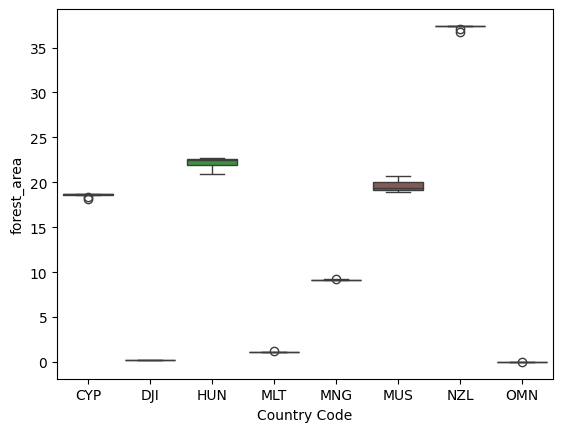

In [162]:
big_outliers = ['CYP', 'DJI','HUN', 'MLT', 'MNG', 'MUS', 'NZL', 'OMN' ]
data = forest[forest['Country Code'].isin(big_outliers)]
sns.boxplot(x='Country Code', y='forest_area', data= data, hue = 'Country Code', legend=False)


<Axes: xlabel='Year', ylabel='forest_area'>

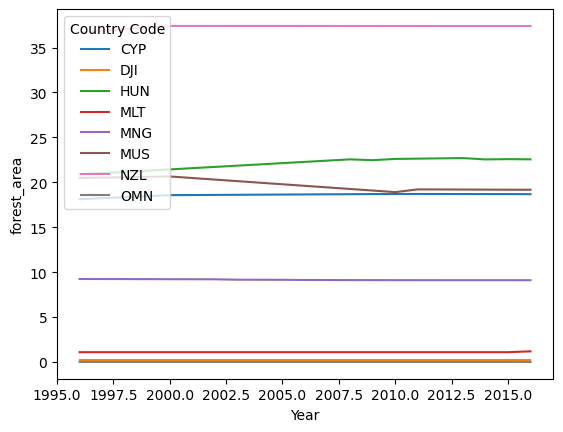

In [156]:

sns.lineplot(x='Year', y='forest_area', data= data, hue = 'Country Code')

In [161]:
display(data)
data.describe()

,Country Code,Country Name,Year,forest_area,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
612,CYP,Cyprus,1996.0,18.117965,880058.0,9240.0,1.035754,0.387752,1.171664,1.261967,0.857321,1.331288,38.199806,0.353475,18.572511
613,CYP,Cyprus,1998.0,18.345238,914660.0,9240.0,0.983077,0.222173,1.195836,1.155307,0.945577,1.061724,41.583926,0.353623,18.599134
614,CYP,Cyprus,2000.0,18.572511,948237.0,9240.0,1.057137,0.517500,1.074904,1.087765,1.016059,1.081236,44.867800,0.354425,18.625758
615,CYP,Cyprus,2002.0,18.599134,982194.0,9240.0,1.117119,0.199421,1.295337,1.193390,0.989594,1.126284,39.757087,0.355396,18.652381
616,CYP,Cyprus,2003.0,18.612446,1000350.0,9240.0,0.994463,0.532276,1.123274,1.181730,0.938782,1.192308,45.459907,0.355105,18.665693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,OMN,Oman,2012.0,0.009693,3535579.0,309500.0,-1.021670,0.462077,0.242914,0.466739,0.518843,0.175083,54.273040,0.409452,0.009047
1940,OMN,Oman,2013.0,0.009693,3816680.0,309500.0,-1.038642,0.459530,0.194771,0.471202,0.486907,0.152670,54.213745,0.408993,0.008724
1941,OMN,Oman,2014.0,0.009693,4009267.0,309500.0,-1.090706,0.734907,0.248718,0.688468,0.485295,0.304765,55.839686,0.406456,0.008401
1942,OMN,Oman,2015.0,0.009693,4191776.0,309500.0,-1.061447,0.778052,0.035525,0.557435,0.352039,0.236283,57.137915,0.408233,0.008078


,Year,forest_area,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
count,144.000000,144.000000,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,2007.166667,13.532612,2.931812e+06,2.815503e+05,0.465798,0.761609,0.564656,0.658530,0.670920,0.539182,38.225653,0.413699,13.559008
std,5.747605,12.486983,2.966536e+06,4.962864e+05,0.957549,0.518882,0.841134,0.801119,0.814475,0.856313,22.956187,0.154105,12.506229
min,1996.000000,0.009047,3.799050e+05,3.200000e+02,-1.471035,-0.964447,-1.081616,-1.002804,-1.000654,-0.761497,-36.333918,0.250921,0.008078
25%,2003.000000,0.880709,9.795838e+05,7.437500e+03,-0.125116,0.539755,0.002557,-0.100348,0.295539,0.098477,22.299592,0.292341,0.882866
50%,2007.500000,13.679243,1.736852e+06,5.639500e+04,0.883531,0.809257,0.744909,0.896416,0.854275,0.452116,42.348902,0.380926,13.895129
75%,2012.000000,20.716902,3.880400e+06,2.748575e+05,1.153546,1.116139,1.156808,1.197957,1.127603,0.925213,56.901168,0.459195,20.850590
max,2016.000000,37.410049,1.031124e+07,1.557465e+06,1.678681,1.598263,1.940045,2.027464,2.004161,2.380319,70.928747,0.858188,37.570126


Maybe consider removing at least DJI as it is constant and MLT is almost constant except for year 2016, and OMN is the same. 

# Data splitting

In [190]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Data splitting in training, validation and test sets. 

In [188]:
#Defining the features (X) and the target variable (y)
X = forest.drop(columns=['Country Name', 'lagged_forest', 'forest_area', 'land_area'])
y = forest['lagged_forest'] 

#Defining the group variable (Country)
groups = forest['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42) 
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]


In [189]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 11) (1908,)
Validation set shape: (414, 11) (414,)
Test set shape: (414, 11) (414,)


In [171]:
#Combining the X and y again, because mixedlm takes in both at the same time 
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)


In [185]:
#Checking if that happened correctly
print(val_data[(val_data['Country Code'] == 'BFA') & (val_data['Year'] == 2000.0)]['forest_area'])

print(forest[(forest['Country Code'] == 'BFA') & (forest['Year'] == 2000.0)]['forest_area'])


218    26.376096
Name: forest_area, dtype: float64
218    26.376096
Name: forest_area, dtype: float64


Checking training data for representative sample. 

In [ ]:
#How to?

# Data modelling 

## Baseline median model 

## Simple baseline linear model

In [193]:
#Defining the formula for the mixed effects model
formula = 'lagged_forest ~ Year + population'

#Fitting the model on the training set
model = smf.mixedlm(formula, data=train_data, groups=train_data['Country Code'])

fit_model = model.fit()

# Print the summary of the fitted model
print(fit_model.summary())

# Function to evaluate the model
def evaluate_model(fit_model, data, target):
    # Make predictions
    data['predictions'] = fit_model.predict(data)
    # Calculate residuals
    data['residuals'] = data[target] - data['predictions']
    # Print evaluation metrics
    rmse = np.sqrt(np.mean(data['residuals']**2))
    mae = np.mean(np.abs(data['residuals']))
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    rmse = np.sqrt(mean_squared_error(data[target], data['predictions']))
    mae = mean_absolute_error(data[target], data['predictions'])
    mape = mean_absolute_percentage_error(data[target], data['predictions'])
    r2 = r2_score(data[target], data['predictions'])
    
    return rmse, mae, mape, r2

# Evaluate the model on validation and test sets
print("Validation Set Performance:")
rmse_val, mae_val = evaluate_model(fit_model, val_data, val_data['lagged_forest'])

print("Test Set Performance:")
rmse_test, mae_test = evaluate_model(fit_model, test_data, 'lagged_forest')

# Save the evaluation metrics in a dictionary
performances = [
    {'split': 'val', 'rmse': rmse_val, 'mae': mae_val},
    {'split': 'test', 'rmse': rmse_test, 'mae': mae_test}
]

print(performances)

    #Calculating performance metrics

    
 #   performances_dummy.append({
  #      'model': model_name,
   #     'split': nsplit,
    #    'rmse': round(rmse, 4),
     #   'mae': round(mae, 4),
      #  'mape': round(mape, 4),
       # 'r2': round(r2, 4)
   # })

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lagged_forest
No. Observations: 1908    Method:             REML         
No. Groups:       106     Scale:              1.6049       
Min. group size:  18      Log-Likelihood:     -3641.9477   
Max. group size:  18      Converged:          Yes          
Mean group size:  18.0                                     
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025  0.975]
-----------------------------------------------------------
Intercept      119.568   11.025 10.845 0.000 97.959 141.177
Year            -0.043    0.005 -8.042 0.000 -0.054  -0.033
population       0.000    0.000  0.218 0.828 -0.000   0.000
Group Var      565.167   63.351                            

Validation Set Performance:


KeyError: "None of [Index([26.3760964912281, 26.0105994152047, 25.6451023391813, 25.2796052631579,\n       25.0968567251462, 24.9141081871345, 24.7313596491228, 24.5486111111111,\n       24.3657894736842, 24.1829678362573,\n       ...\n       36.2838392124692, 36.2838392124692, 36.2838392124692, 36.2838392124692,\n       36.2838392124692, 36.2838392124692, 36.2838392124692, 36.2838392124692,\n       36.2838392124692, 36.2838392124692],\n      dtype='float64', length=414)] are in the [columns]"

In [169]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pickle as pkl

#Defining the model name
model_name = "simple_forest"

#Defining the formula for the mixed effects model
formula = 'lagged_forest ~ Year + population'

#Fitting the mixed effects model
dummy = smf.mixedlm(formula=formula, data=X_train, groups=X_train['Country Code']).fit()

#Save the model
with open('ghg_mixedlm.pkl', 'wb') as file:
    pkl.dump(dummy, file)

#Initialize a list to store performance metrics
performances_dummy = []

#Defining a function to predict using the mixed effects model
def predict_mixedlm(model, df, group):
    df = df.copy()
    df['prediction'] = model.predict(df)
    group = df['Country Code']
    
    return df['prediction']

#Evaluating the model on train, validation, and test sets
for x, nsplit, name in zip([X_train, X_val, X_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Predict using the mixed effects model
    preds = predict_mixedlm(dummy, x)
    
    #Calculating performance metrics
    rmse = np.sqrt(mean_squared_error(x['lagged_forest'], preds))
    mae = mean_absolute_error(x['lagged_forest'], preds)
    mape = mean_absolute_percentage_error(x['lagged_forest'], preds)
    r2 = r2_score(x['lagged_forest'], preds)
    
    performances_dummy.append({
        'model': model_name,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4),
        'r2': round(r2, 4)
    })

for performance in performances_dummy:
    print(performance)


{'model': 'simple_forest', 'split': 'train', 'rmse': 23.6871, 'mae': 19.601, 'mape': 38.0355, 'r2': -0.0004}
{'model': 'simple_forest', 'split': 'val', 'rmse': 24.2185, 'mae': 19.9147, 'mape': 4.3567, 'r2': -0.0478}
{'model': 'simple_forest', 'split': 'test', 'rmse': 27.4078, 'mae': 22.3644, 'mape': 10.3959, 'r2': -0.0205}


# Modeling forest data 

In [ ]:
forest = pd.read_csv('forest-modelling.csv')

forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6849 non-null   object 
 1   Indicator Name      6849 non-null   object 
 2   Indicator Code      6849 non-null   object 
 3   Year                6849 non-null   float64
 4   forest_area         6661 non-null   float64
 5   Country Name        6849 non-null   object 
 6   Population, total   6688 non-null   float64
 7   Land area (sq. km)  6500 non-null   float64
 8   WGI VA              4394 non-null   float64
 9   WGI PS              4381 non-null   float64
 10  WGI GE              4335 non-null   float64
 11  WGI RQ              4338 non-null   float64
 12  WGI RL              4418 non-null   float64
 13  WGI CC              4354 non-null   float64
 14  Education           3846 non-null   float64
 15  Innovation          3105 non-null   float64
 16  Social

In [ ]:
print(forest_full.isna().sum())

Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area            188
Country Name             0
Population, total      161
Land area (sq. km)     349
WGI VA                2455
WGI PS                2468
WGI GE                2514
WGI RQ                2511
WGI RL                2431
WGI CC                2495
Education             3003
Innovation            3744
Social Inequality     4950
ICT                   3197
dtype: int64


In [ ]:
forest = forest_full.drop(columns=['ICT', 'Innovation'])

forest = forest.dropna()
print(forest)

     Country Code                Indicator Name  Indicator Code    Year  \
1257          ALB  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1265          AUT  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1280          BRA  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1286          CAN  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1288          CHL  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
...           ...                           ...             ...     ...   
6813          SWE  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6821          THA  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6827          TUN  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6834          URY  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6835          USA  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   

      forest_area   Country Name  Population, total  Land area (sq. km)  \
1257    28.361314       

In [ ]:
countries_without_nans = forest.dropna(subset=forest.columns, how='any')['Country Code'].unique()

len(countries_without_nans)

134

In [ ]:
len(forest['Country Code'].unique())

forest.describe()

,Year,forest_area,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Social Inequality
count,1228.000000,1228.000000,1.228000e+03,1.228000e+03,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,2011.052117,31.589070,5.926650e+07,1.067069e+06,0.384096,0.106379,0.425366,0.463525,0.319351,0.300858,52.597148,6.941775
std,6.346081,19.363088,1.928120e+08,2.713946e+06,0.913825,0.864469,0.935872,0.890138,0.999573,1.058701,25.656362,1.889426
min,1996.000000,0.045186,4.472800e+04,1.800000e+02,-1.833387,-2.810035,-2.336034,-2.242906,-1.976794,-1.759068,0.456960,1.600000
25%,2006.000000,13.053363,4.005037e+06,4.808000e+04,-0.233657,-0.472843,-0.348622,-0.245562,-0.537161,-0.562483,34.835217,5.700000
50%,2012.000000,31.474027,9.511978e+06,1.750200e+05,0.490304,0.207683,0.328050,0.472256,0.212978,0.038138,55.439854,7.100000
75%,2016.000000,45.014950,4.417752e+07,5.475570e+05,1.139616,0.802297,1.210805,1.216194,1.178231,1.197882,70.943386,8.400000
max,2021.000000,80.216075,1.411100e+09,1.638139e+07,1.800992,1.720112,2.347191,2.039989,2.124782,2.459118,150.201767,10.500000


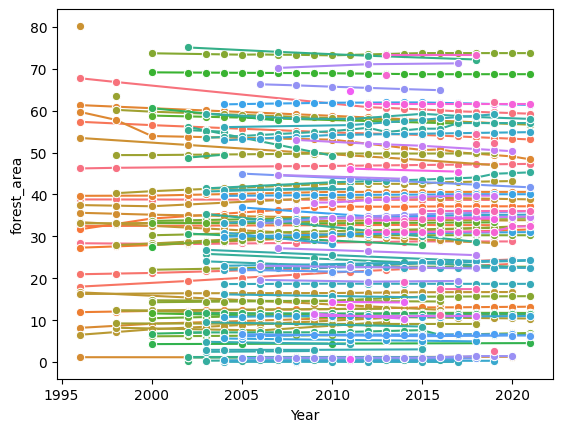

In [ ]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

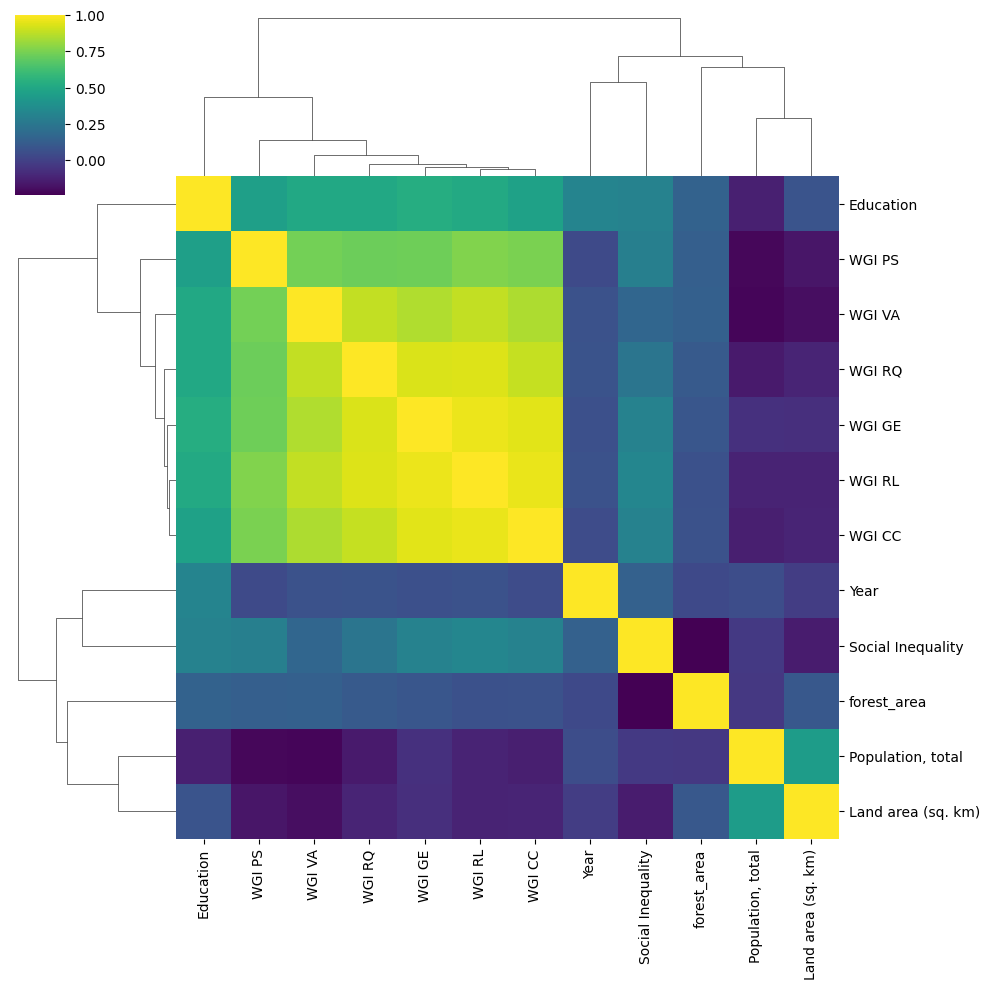

In [ ]:
forest_num = forest[forest.select_dtypes(exclude=['object']).columns]

sns.clustermap(forest_num.corr(), cmap='viridis')
plt.show()